In [ ]:
# some imports before we start...
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import torch

# Alien duel study
The best introduction to the study is to play the game yourself, which you can do here:

https://kyblab.tuebingen.mpg.de/experiment_ccs2022/experiment_ccs2023/banditexperiment/.

Please go there, read the instructions and play a few rounds. Once you have a feeling for how to play the game, please read the following summary, to consolidate the rules and get used to the vocabulary we will use here.

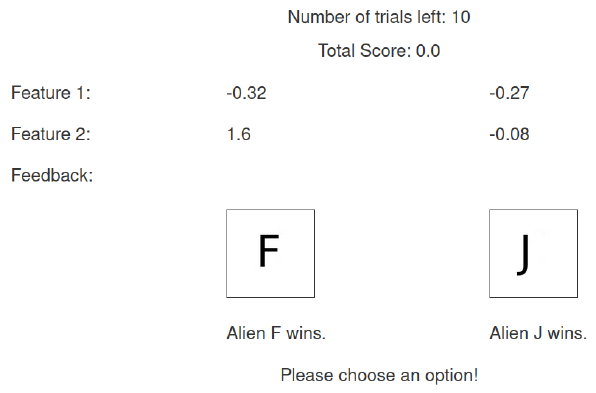

## Summary
In this study, subjects had to make predictions about which alien would win in a duel.
As you can see in the image, the aliens are called F and J (as these two keyboard keys were used as response buttons).
The aliens have 2 features (imagine e.g. size and speed), with numeric values.
In every duel you have to infer which alien would win, by applying your knowledge of how important the features are on the given planet (think: discipline).
For example, a high value for a feature can be good (e.g. speed in a running competition), but it could also be bad (e.g. physical weight in a running competition).

There are always 10 pairs of aliens per planet, i.e. 10 trials per block. Then you are beamed to another planet (a new block starts), where they compete in a different discipline, so you have to learn the new feature importance.

People's goal is to maximise the amount of correct bets on which alien is going to win. Importantly, they are not rewarded by how close they predict the actual feedback values (e.g. alien F having outcome 0.83).

## Data
N = 15 students from a Computational Cognitive Science class have performed the experiment.

Further 15 participants were simulated by letting a Large Language Model (LLM) play the game with the same instructions and by prompt-chaining the trials and choices within each planet.

Here is the data set of these N=30 natural and artificial participants.

**Important! To access the data, download `ccs2023_data.csv` from [the Google Drive](https://drive.google.com/file/d/1l3-evmSDgq4nNgbPrExAEzvSWJiSQh3X/view?usp=sharing), and then upload it into google colab by clicking on the folder symbol in the left side bar.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# loading data
data_path = '/content/drive/MyDrive/Code/IICCSSS Hackathon/ccs2023_data.csv'
df = pd.read_csv(data_path)
df

,Unnamed: 0,num_features,task,trial,w0,w1,w2,w3,xf0,xf1,...,xj1,xj2,xj3,yf,yj,J_pressed,J_wins,is_llm,participant,RT
0,0,2,0,0,-0.696263,-0.699151,0.0,0.0,1.106486,-0.704793,...,0.806271,0.0,0.0,-0.277650,-0.526670,1.0,0.0,1,0,NaN
1,1,2,0,1,-0.696263,-0.699151,0.0,0.0,-0.489473,0.844319,...,0.886357,0.0,0.0,-0.249504,0.114588,0.0,1.0,1,0,NaN
2,2,2,0,2,-0.696263,-0.699151,0.0,0.0,-1.276077,-0.305100,...,-2.359620,0.0,0.0,1.101796,1.887954,0.0,1.0,1,0,NaN
3,3,2,0,3,-0.696263,-0.699151,0.0,0.0,1.501713,-0.201051,...,0.181713,0.0,0.0,-0.905022,-0.300708,0.0,1.0,1,0,NaN
4,4,2,0,4,-0.696263,-0.699151,0.0,0.0,-0.230728,-0.697054,...,-1.732584,0.0,0.0,0.647993,0.060549,0.0,0.0,1,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,195,2,19,5,-0.999596,0.280440,0.0,0.0,-0.538121,-0.362382,...,0.177843,0.0,0.0,0.436278,0.263946,0.0,0.0,0,29,8287.0
5996,196,2,19,6,-0.999596,0.280440,0.0,0.0,-0.685851,0.026450,...,1.046967,0.0,0.0,0.692991,-0.302917,0.0,0.0,0,29,1954.0
5997,197,2,19,7,-0.999596,0.280440,0.0,0.0,0.530588,-0.989813,...,0.780360,0.0,0.0,-0.807956,0.475209,1.0,1.0,0,29,4877.0
5998,198,2,19,8,-0.999596,0.280440,0.0,0.0,-0.898990,0.498981,...,1.620135,0.0,0.0,1.038561,-0.135593,0.0,0.0,0,29,3595.0


In [ ]:
# df has the following columns (just for future reference!)
df.columns
# num_features you can ignore, it's always 2
# task = "planet" = "block"
# trial = "duel"
# w0, w1: the weights
# w2, w3: ignore these, since we only have num_features = 2
# xf0, xf1, xj0, xj1: the input values (how much of feature 0 and 1 alien J and F have)
# xf2, xf3, xj2, xj3: again, ignore these
# yf, yj: the outputs, the scores for each alien in a fight
# J_pressed: 1 if alien J was selected, 0 if F was selected
# J_wins: 1 if alien J wins, 0 if F wins[r]
# is_llm: if the participant is simulated from an LLM
# RT: reaction time (does not apply to LLM generated data)

Index(['Unnamed: 0', 'num_features', 'task', 'trial', 'w0', 'w1', 'w2', 'w3',
       'xf0', 'xf1', 'xf2', 'xf3', 'xj0', 'xj1', 'xj2', 'xj3', 'yf', 'yj',
       'J_pressed', 'J_wins', 'is_llm', 'participant', 'RT'],
      dtype='object')

## Verification of data


In [ ]:
print(df.iloc[0]['w0'] * df.iloc[0]['xf0'] + df.iloc[0]['w1'] * df.iloc[0]['xf1'])
print(df.iloc[0]['yf'])

-0.27764964475413123
-0.2776496410369873


In [ ]:
print(df.iloc[0]['w0'] * df.iloc[0]['xj0'] + df.iloc[0]['w1'] * df.iloc[0]['xj1'])
print(df.iloc[0]['yj'])

-0.5266699212694232
-0.5266699194908142


In [ ]:
df.iloc[0]['J_wins']

0.0

## Exploring the data
You can already explore the dataset here, if you want to. Some questions you might ask, are:

* Do participants perform better than chance?
* Do they improve over trials within each round?
* Do they improve over rounds?
* Do people or LLMs perform better?

In [ ]:
df_humans = df.loc[df['is_llm'] == 0]
df_llm = df.loc[df['is_llm'] == 1]

In [ ]:
# participant performance
n_wins_all = np.sum(df['J_pressed'] == df['J_wins'])
print(f"Success rate of all participants: {np.round(n_wins_all/len(df), 4) * 100}")

n_wins_humans = np.sum(df_humans['J_pressed'] == df_humans['J_wins'])
print(f"Success rate of human participants: {np.round(n_wins_humans/len(df_humans), 4) * 100}")

n_wins_llm = np.sum(df_llm['J_pressed'] == df_llm['J_wins'])
print(f"Success rate of llm participants: {np.round(n_wins_llm/len(df_llm), 4) * 100}")

Success rate of all participants: 73.8
Success rate of human participants: 74.17
Success rate of llm participants: 73.42999999999999


In [ ]:
# block performance
block_performance = pd

for block in range(20):
  df_block = df.loc[df['task']==block]
  df_block_human = df_block.loc[df['is_llm'] == 0]
  df_block_llm = df_block.loc[df['is_llm'] == 1]

  block_performance[block] = {}
  n_wins_block_all = np.sum(df_block['J_pressed'] == df_block['J_wins'])
  n_wins_block_human = np.sum(df_block_human['J_pressed'] == df_block_human['J_wins'])
  n_wins_block_llm = np.sum(df_block_llm['J_pressed'] == df_block_llm['J_wins'])

  block_performance[block]['all'] = np.round(n_wins_block_all / len(df_block), 4)
  block_performance[block]['human'] = np.round(n_wins_block_human / len (df_block), 4)
  block_performance[block]['llm'] = np.round(n_wins_block_llm / len(df_block), 4)




In [ ]:
block_performance

{0: {'all': 0.7467, 'human': 0.3833, 'llm': 0.3633},
 1: {'all': 0.71, 'human': 0.3533, 'llm': 0.3567},
 2: {'all': 0.6933, 'human': 0.32, 'llm': 0.3733},
 3: {'all': 0.72, 'human': 0.3567, 'llm': 0.3633},
 4: {'all': 0.6967, 'human': 0.35, 'llm': 0.3467},
 5: {'all': 0.7433, 'human': 0.3433, 'llm': 0.4},
 6: {'all': 0.76, 'human': 0.3967, 'llm': 0.3633},
 7: {'all': 0.75, 'human': 0.3733, 'llm': 0.3767},
 8: {'all': 0.7033, 'human': 0.3367, 'llm': 0.3667},
 9: {'all': 0.73, 'human': 0.3967, 'llm': 0.3333},
 10: {'all': 0.77, 'human': 0.3933, 'llm': 0.3767},
 11: {'all': 0.7433, 'human': 0.3667, 'llm': 0.3767},
 12: {'all': 0.7533, 'human': 0.3833, 'llm': 0.37},
 13: {'all': 0.74, 'human': 0.38, 'llm': 0.36},
 14: {'all': 0.8233, 'human': 0.4167, 'llm': 0.4067},
 15: {'all': 0.7367, 'human': 0.3667, 'llm': 0.37},
 16: {'all': 0.7533, 'human': 0.3767, 'llm': 0.3767},
 17: {'all': 0.7133, 'human': 0.3633, 'llm': 0.35},
 18: {'all': 0.75, 'human': 0.37, 'llm': 0.38},
 19: {'all': 0.7233, 

In [ ]:
block_performance_df = pd.DataFrame.from_dict(block_performance)
block_performance_df

<Axes: >

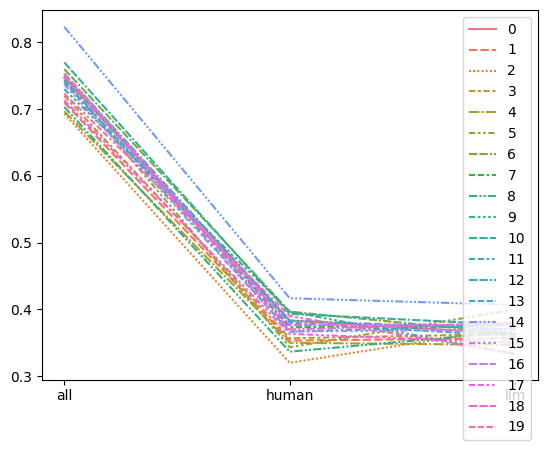

In [ ]:
sns.lineplot(block_performance, x_axis)

# Generative (= true) model

The game is simulated by first sampling the true importance weights for a given block from a standard normal distribution:
$$ w_i \sim \mathcal{N}(0,1) \text{  for  } i \in \{ 0,1\}.$$
These weights stay constant throughout a whole block.

Secondly, we sample a value $x$ for each alien, again from a standard normal, that describes how much of the features they have.
This changes from trial to trial, therefore we include the index $t$.
$$
xF_{i, t} \sim \mathcal{N}(0,1) \text{  for  } i \in \{ 0,1\}\\
xJ_{i, t} \sim \mathcal{N}(0,1) \text{  for  } i \in \{ 0,1\}.$$

Then the outcome $y$ of each alien is calculated as
$$
yF_{t} = w_0 \cdot xF_{0, t} + w_1 \cdot xF_{1, t} \qquad (1)\\
yJ_{t} = w_0 \cdot xJ_{0, t} + w_1 \cdot xJ_{1, t} \qquad (2)
$$

# Optimal model
What is the optimal way to get the two unknown weights $w_i$ from the two equations (1) and (2)? Well, it's a linear system of equations. All $x$'s and both $y$'s are observed after selecting an alien, so we can just solve for the $w$'s, e.g. via Gaussian elimination or plugging in one equation into the other. This is basic school math, we could even do it by hand (but it's nasty, so **you don't need to follow this derivation!**):
$$
\begin{align}
w_0 &= (yF - w_1 \cdot xF_1) / xF_0 \qquad (*)\\
w_1 &= (yJ - w_0 \cdot xJ_0) / xJ_1 \qquad \text{and we plug in (*)} \\
&= (yJ - [yF - w_1 \cdot xF_1) / xF_0] \cdot xJ_0) / xJ_1 \\
&= yJ / xJ_1 - (yF\cdot xJ_0) / (xF_0 \cdot xJ_1) + w_1 \cdot (xF_1 \cdot xJ_0) / (xF_0 \cdot xJ_1) \\
\Leftrightarrow w_1 &= [yJ / xJ_1 - (yF\cdot xJ_0) / (xF_0 \cdot xJ_1)] \; / \; [1- (xF_1 \cdot xJ_0) / (xF_0 \cdot xJ_1)] \qquad \text{and we plug this back into (*)} \\
w_0 &= (yF - [yJ / xJ_1 - (yF\cdot xJ_0) / (xF_0 \cdot xJ_1)] \; / \; [1- (xF_1 \cdot xJ_0) / (xF_0 \cdot xJ_1)] \cdot xF_1) / xF_0
\end{align}
$$

Admittedly, this is a mouthful, and is nothing that you do in your head while you see the feedback $y$ values for 2 seconds. But for a computer this is not a problem, we can ask a linear equation solver to do it for us.

The key is, that we only have to do this once, and then we know the weights. Thus, only for the first trial on each planet we have to guess an alien, observe the outcomes of the fight, and after that we can predict and act optimally using the knowledge that the outcomes are just a linear combination of the features with the inferred weights.

In [ ]:
class OptimalAgent():
    def __init__(self):
        self.w = np.zeros([2,1])

    def reset(self):
        """
        Reset the internal model (here: weights).
        Call this after each planet!
        """
        self.w = np.zeros([2,1])

    def predict(self, xF, xJ):
        """
        Predict the y values.
        """
        yF_estimated = xF @ self.w
        yJ_estimated = xJ @ self.w
        return yF_estimated, yJ_estimated

    def update(self, trial, xF, xJ, yF, yJ, J_pressed=None):
        """
        Update the internal model.
        """
        if trial == 0: # only after the first trial we have to learn
            X = np.vstack([xF, xJ])
            y = np.vstack([yF, yJ])
            self.w = np.linalg.solve(X, y) # this linear equation solver does all the hard work

# Environment and simulation
To test our `OptimalAgent`, we reverse-engineer the game, which in Reinforcement Learning jargon, is called the "environment". The agent and the environment build a loop, in which the agent picks an action and the environment delivers the rewards and observations back to the agent.

Doing so, we can later plug in many different agents which all can play the game. The goal of modelling is to build an agent that matches the participant data as close as possible.

In [ ]:
class RandomEnvironment():
    """
    This environment can be used to play a new game.
    Weights and inputs are sampled from standard normals.
    Ignore the parameters participant, planet and trial.
    """
    def __init__(self):
        pass

    def sample_weights(self, participant, planet):
        w = np.random.randn(2, 1) # sample two weights from standard normal
        return w

    def sample_inputs(self, participant, planet, trial):
        # sample input vectors
        xF = np.random.randn(1,2) # sample inputs for F from standard normal
        xJ = np.random.randn(1,2) # sample inputs for J from standard normal
        return xF, xJ


class DataEnvironment():
    """
    This environment can be used to repeat the real data of the participants.
    Weights and inputs are not sampled again, but we look them up in the data
    for a given participant, planet and trial.
    """
    def __init__(self):
        # loading data
        self.df = pd.read_csv(data_path)

    def sample_weights(self, participant, planet):
        df = self.df
        row = df[(df["participant"] == participant) & (df["task"] == planet)].iloc[0]
        return np.array([row["w0"], row["w1"]])[:,np.newaxis]

    def sample_inputs(self, participant, planet, trial):
        df = self.df
        row = df[(df["participant"] == participant) & (df["task"] == planet) & (df["trial"] == trial)]
        return np.array([row["xf0"], row["xf1"]]).T, \
               np.array([row["xj0"], row["xj1"]]).T

    def sample_Jpress(self, participant, planet, trial):
        df = self.df
        row = df[(df["participant"] == participant) & (df["task"] == planet) & (df["trial"] == trial)]
        return row['J_pressed']



## Simulation
Now we simulate the game for a single participant, with 20 planets and 10 trials per planet.
Note how agent and environment take turns in the inner loop.

In [ ]:
# just define some constants
n_planets = 20
n_trials_per_planet = 10
n_participants = 30

In [ ]:
def simulate_participant(agent, environment, participant=0):
    actions = []
    correct_actions = []

    for planet in range(n_planets): # loop over planets
        # environment: sample true weights for planet
        true_weights = environment.sample_weights(participant, planet)

        # reset the agent: to discard knowledge from the previous planet
        agent.reset()

        for trial in range(n_trials_per_planet): # loop over trials
            # environment: sample input values for trial
            xF, xJ = environment.sample_inputs(participant, planet, trial)
            J_pressed = environment.sample_Jpress(participant,planet,trial)
            # agent: make choice
            yF_estimate, yJ_estimate = agent.predict(xF, xJ)
            action = 0 if yF_estimate > yJ_estimate else 1 # select the winner (greedily)
            actions += [action] # append the action to a list

            # environment: compute feedback
            yF = xF @ true_weights
            yJ = xJ @ true_weights
            correct_action = 0 if yF > yJ else 1
            correct_actions += [correct_action]

            # agent: learn from that feedback
            agent.update(trial, xF, xJ, yF, yJ, J_pressed)

    return np.array(actions), np.array(correct_actions)

## Let's simulate real data
We can also simulate our agent with the exact inputs and weights that the participants have seen, and then compare its actions to the participants' actions.
To do so, we take the `DataEnvironment` instead of the `RandomEnvironment`, which takes the weights and inputs from the data frame instead of sampling them on the go.

First, let's look at a single participant:

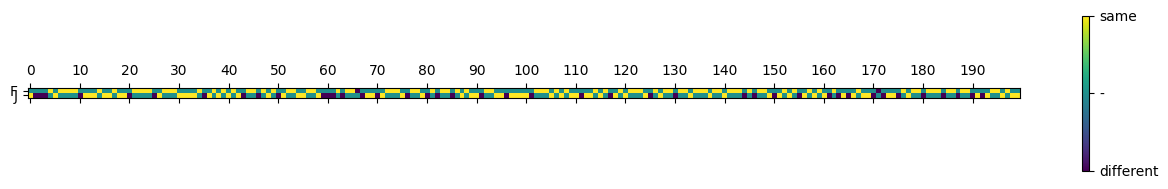

In [ ]:
agent = OptimalAgent()
environment = DataEnvironment()

# which participant
participant = 0

actions, correct_actions = simulate_participant(agent, environment, participant)
match = actions == correct_actions # does the agent agree with the correct action?

# how well does the agent match our participant
df_part = df[df["participant"] == participant]
participant_actions = df_part["J_pressed"].to_numpy()
participant_match = actions == participant_actions

n_trials = n_planets * n_trials_per_planet
actions_matrix = np.zeros([2, n_trials])
actions_matrix[actions, range(n_trials)] = participant_match * 2 - 1 # -1 or 1 for wrong or right

plt.matshow(actions_matrix)
plt.xticks(range(0, n_trials, n_trials_per_planet))
plt.yticks([0,1], ["F", "J"])
cbar = plt.colorbar(ticks=[-1, 0, 1])
cbar.ax.set_yticklabels(['different', '-', 'same'])  # vertically oriented colorbar

plt.show()

Finally, let's do the same for all participants, to see how much the `OptimalAgent` agrees with the participants on average.
We can even determine, which participant is the closest to optimal.

In [ ]:
def simulate_all_participants(agent, environment, n_participants=30):
    actions_all = []
    correct_actions_all = []
    for participant in range(n_participants):
        actions, correct_actions = simulate_participant(agent, environment, participant)
        actions_all += [actions]
        correct_actions_all += [correct_actions]
    return np.array(actions_all).flatten(), np.array(correct_actions_all).flatten()

agent = OptimalAgent()
environment = DataEnvironment()
actions_all, _ = simulate_all_participants(agent, environment)

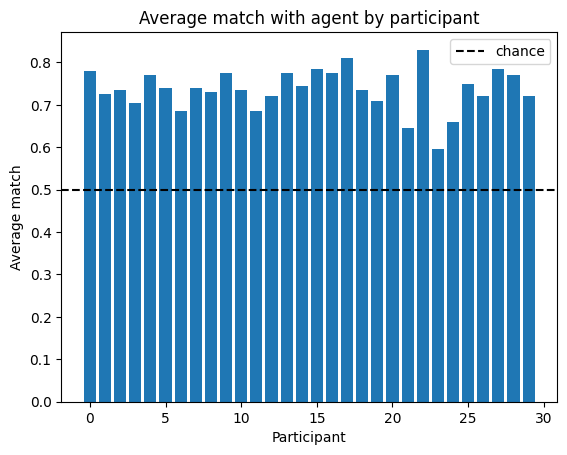

In [ ]:
def plot_match_by_participant(df, actions_all, n_participants=30):
    # join the simulated data with the participant data frame
    df["J_pressed_agent"] = actions_all
    df["match_agent"] = df["J_pressed_agent"] == df["J_pressed"]
    match_per_participant = df.groupby("participant").agg({"match_agent": np.mean}).to_numpy().flatten()
    plt.bar(range(n_participants), match_per_participant)
    plt.axhline(y=0.5, linestyle="--", c="k")
    plt.legend(["chance"])
    plt.title("Average match with agent by participant")
    plt.ylabel("Average match")
    plt.xlabel("Participant")
    plt.show()


plot_match_by_participant(df, actions_all)

In [ ]:
model_matches = {}

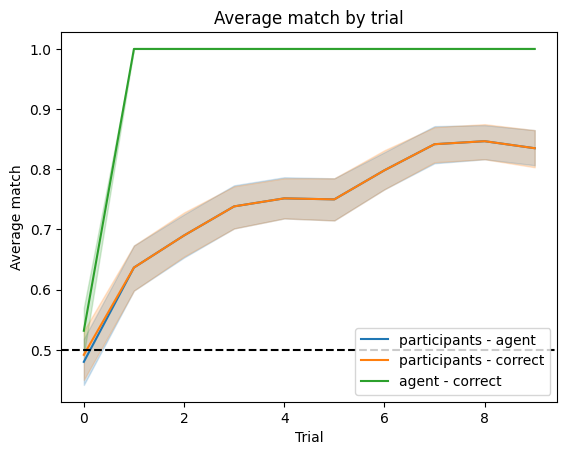

In [ ]:
# we can also plot the match over trials (averaging over planets and participants)
# hypothesis: in later trials participants should become more optimal

def plot_match_by_trial(df, actions_all, condition=None, title="Average match by trial", model="optimal"):
    # join the simulated data with the participant data frame
    df["J_pressed_agent"] = actions_all
    df["match_participant_agent"] = df["J_pressed"] == df["J_pressed_agent"]
    df["match_participant_correct"] = df["J_pressed"] == df["J_wins"]
    df["match_agent_correct"] = df["J_pressed_agent"] == df["J_wins"]
    if condition is not None:
      df = df[lambda x: condition(x)]
    sns.lineplot(df, x="trial", y="match_participant_agent", label="participants - agent")
    sns.lineplot(df, x="trial", y="match_participant_correct", label="participants - correct")
    sns.lineplot(df, x="trial", y="match_agent_correct", label="agent - correct")
    plt.axhline(y=0.5, linestyle="--", c="k")
    plt.title(title)
    plt.ylabel("Average match")
    plt.xlabel("Trial")
    model_matches[model] = np.mean(df["match_participant_agent"])
    plt.show()

plot_match_by_trial(df, actions_all)

In [ ]:
model_matches

{'optimal': 0.7368333333333333}

# Your task: build a realistic model!
As we have discussed already, the `OptimalAgent` is totally unrealistic, because it assumes that humans can do linear algebra in their heads and that they are not noisy. Therefore, the next question is:

**How do we learn the weights iteratively, if not one-shot by solving a linear system of equations?**

Here are some ideas on which kind of models you could choose (you might not have time to try all of them!):

1. **Gradient descent**: Just learn the weights in a supervised fashion, adapting them step by step. One parameter that you can fit here is the learning rate (people might have different learning rates).
2. **Bayesian modelling**: Have a belief about which range the weights are in. For instance, you could discretise into strongly negative, near zero and strongly positive weights. Update this belief with every trial. How do you draw predictions from this belief?
3. **Recurrent neural networks (RNN)**: Build an RNN that learns a hidden state over trials. This hidden state must not correspond to the weights, so this model will be _less interpretable_, but might be very predictive, since it can also use information of previous actions. You might either train the RNN on artificial data (e.g. generated by the `OptimalAgent` in the `RandomEnvironment`) or you can train it on a part of the participants.


In general, there are some **extensions** that you can include to make your model more realistic and thus better match with the participant data:
* include additional constraints on how much information you want to use from the feedback in each trial (e.g. you could use only the information about the winner and not the exact outcome)
* add noise to the output (e.g. in 5% of cases, choose a random alien)
* come up with a sparse model, that only uses a single feature to predict the winner and ignores the other

**Comparing human participants to LLMs**:
* are there any performance differences between human and LLM participants?
* what are typical errors that humans do, but not the LLMs, or vice versa?
* how much history do humans and LLMs take into account?

**General coding advice**:
* write an agent class that adopts the same format as the `OptimalAgent` (including `reset`, `predict` and `update` function)
* you can use the functions `simulate_(all_)participant(s)` and the `plot_match_by_{participant, trial}` plotting functions from above to score your model
* if you want to compare different models among each other, you might want to come up with an agreement matrix, and/or use measures like the [Bayesian Information Criterion](https://en.wikipedia.org/wiki/Bayesian_information_criterion) which penalizes model complexity (carefull: does not make sense for RNNs; why?)


## 1. Gradient descent
Learning the weights can be done by gradient descent. For those of you who are familiar with Neural networks, just imagine we were training a network with two input units and one output unit. This network has two weights, $w_0$ from the first input unit to the output unit, and $w_1$ from the second input to the output unit. Every trial provides two training examples, since we get a pair of inputs $x$ and a label $y$ for each of the two aliens.

We initialise the weights randomly (from the standard normal distribution). In every trial, we let the agent / network make a prediction, we take the corresponding action, observe the outcome and use this label to feed back the error to the weights.

In [ ]:
w = np.array([[1],[2]])
w[1]

array([2])

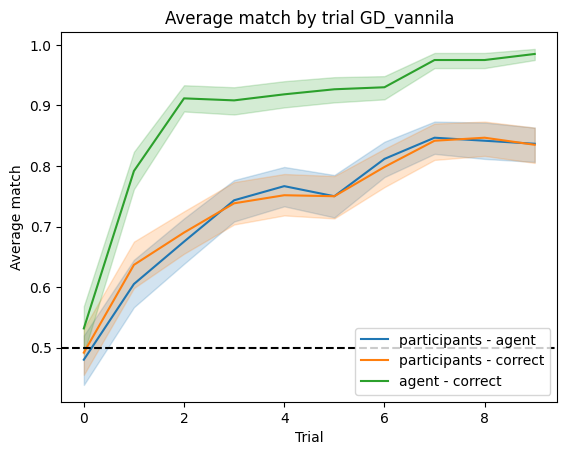

In [ ]:
# gradient descent model for learning weights
class GdAgent():
    def __init__(self):
        self.weights = np.zeros([2,1])
        self.lr = learning_rate
        self.grad = np.zeros((2, 1))
        self.lr = 0.1


    def reset(self):
        self.weights = np.zeros([2,1])
        self.lr = 0.1

    def predict(self, xF, xJ):
        self.yF_estim = xF @ self.weights
        self.yJ_estim = xJ @ self.weights
        return self.yF_estim, self.yJ_estim

    def update(self, trial, xF, xJ, yF, yJ, J_pressed=None):
        F_err = (yF - self.yF_estim)
        J_err = (yJ - self.yJ_estim)
        self.grad = self.lr * (F_err * xF.T + J_err * xJ.T)
        self.weights += self.grad




agent = GdAgent()
environment = DataEnvironment()

actions, correct_actions = simulate_all_participants(agent, environment)

#plot_match_by_participant(df, actions)
plot_match_by_trial(df, actions, title="Average match by trial GD_vannila", model="GD_vanilla")

In [ ]:
model_matches

{'optimal': 0.7368333333333333, 'GD_vanilla': 0.7356666666666667}

## GD 2.0

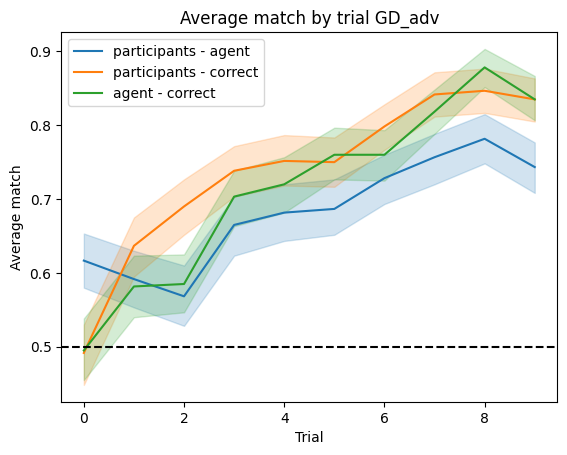

In [ ]:
# gradient descent model for learning weights
class GdAgent():
    def __init__(self):
        self.weights = np.array([[1],[1]])
        self.lr = learning_rate
        self.grad = np.zeros((2, 1))
        self.lr = 0.1


    def reset(self):
        self.weights = np.array([[1],[1]])
        self.lr = 0.1

    def predict(self, xF, xJ):
        self.yF_estim = xF @ self.weights
        self.yJ_estim = xJ @ self.weights
        return self.yF_estim, self.yJ_estim

    def update(self, trial, xF, xJ, yF, yJ, J_pressed=None):
        F_err = (yF - self.yF_estim)
        J_err = (yJ - self.yJ_estim)
        self.grad = self.lr * (F_err * xF.T + J_err * xJ.T)
        self.weights = np.round(((self.grad + self.weights) * 2), 0) / 2




agent = GdAgent()
environment = DataEnvironment()

actions, correct_actions = simulate_all_participants(agent, environment)

# plot_match_by_participant(df, actions)
plot_match_by_trial(df, actions, title="Average match by trial GD_adv", model="GD_adv")
# plot_match_by_trial(df, actions, lambda x: x.is_llm == 1, title="LLM average match by trial",)
# plot_match_by_trial(df, actions, lambda x: x.is_llm == 0, title="Human average match by trial")


The `GdAgent` has one parameter: the learning rate. This could in principle vary from participant to participant. So now we can do **model fitting**, which is the process of finding the best parameter for each participant. This can be done by a simple (grid-) search over a set of parameter values or we can use an optimizer like `scipy.optimize.minimize`.

## Intuitive Agent

In [ ]:
np.array([[1],[2]]).T[0][1]

2

In [ ]:
class IntuitiveAgent():
    def __init__(self):
      self.w = np.array([[1],[1]])
      self.alpha = 0.1

    def reset(self):
      self.w = np.array([1],[-1])
      pass


    def predict(self, xF, xJ):
      self.yF_pred = xF @ self.w
      self.yJ_pred = xJ @ self.w

      return self.yF_pred, self.yJ_pred

    def update(self, trial, xF, xJ, yF, yJ):
      f1_diff = xF[0][0] - xJ[0][0]
      f2_diff = xF[0][1] - xJ[0][1]
      w1 = self.w[0][0]
      w2 = self.w[0][1]
      scaled_f1_diff = f1_diff * w1
      scaled_f2_diff = f2_diff * w2

      sum = scaled_f1_diff + scaled_f2_diff

      # scale up
      if sum < 0 and (yF > yJ)


      y_true_diff = yF-yJ

      # early stages: figuring out if f1 or f2 is more important
      # middle stages: figuring out by how much f1 or f2 is more important
      # final stages: try and use same strategy that has been developed (noise)
      pass

In [ ]:
np.array([[1],[-1]]).shape

(2, 1)

## Simple Neural Network


In [ ]:
import tensorflow as tf

def build_nn():
  model = tf.keras.Sequential()
  model.add(tf.keras.Input(shape=(4,), name="input"))
  model.add(tf.keras.layers.Dense(10, name="hidden"))
  model.add(tf.keras.layers.Dense(3, name="output"),)
  model.compile(optimizer='sgd', loss='mse')
  return model


In [ ]:
class NNagent():
    def __init__(self, n_epochs=10):
      self.model = build_nn()
      self.x_list = []
      self.y_list = []
      self.n_epochs = n_epochs
      print(self.model.summary())

    def reset(self):
      self.model = build_nn()
      self.x_list = []
      self.y_list = []


    def predict(self, xF, xJ):
      if len(self.x_list) > 0:
        xF0, xF1 = xF[0][0], xF[0][1]
        xJ0, xJ1 = xJ[0][0], xJ[0][1]
        print([xF0, xF1, xJ0, xJ1])
        self.pred = self.model.predict([xF0, xF1, xJ0, xJ1])
      else: self.pred = [1,1,0]
      return self.pred[:2]

    def update(self, trial, xF, xJ, yF, yJ, j_pressed):
      xF0, xF1 = xF[0][0], xF[0][1]
      xJ0, xJ1 = xJ[0][0], xJ[0][1]
      self.x_list.append([xF0, xF1, xJ0, xJ1])
      self.y_list.append([yF,yJ,j_pressed])

      self.model.fit(self.x_list, self.y_list, epochs=self.n_epochs, batch_size=1)


In [ ]:
agent = NNagent()
environment = DataEnvironment()

actions, correct_actions = simulate_all_participants(agent, environment)

#plot_match_by_participant(df, actions)
plot_match_by_trial(df, actions)